In [2]:
import os
from datasets import load_dataset
from PIL import Image
import pandas as pd
import torch

In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [4]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full content of each column (no truncation)
pd.set_option('display.width', None)

In [5]:
dataset = load_dataset("ahmedheakl/arocrbench_synthesizear",split="train")

In [6]:
dataset

Dataset({
    features: ['image', 'text', 'source'],
    num_rows: 500
})

In [7]:
results = []
for sample in dataset:
    image = sample["image"]  # Already a PIL Image object
    if image.mode != "RGB":
        image = image.convert("RGB")
    ground_truth = sample["text"]
    results.append({
        "image": image,
        "ground_truth": ground_truth,
        "qari": None,
        
    })
print(f"Initialized results with {len(results)} samples.")

Initialized results with 500 samples.


## Qwenvl2.5 3B 

In [8]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct",use_fast=True)

model = AutoModelForImageTextToText.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct",torch_dtype="auto",device_map="cuda:1")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
from PIL import Image 
import requests

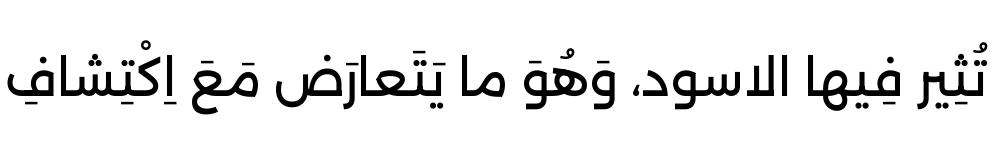

In [10]:
image = dataset[2]['image']
image

In [10]:
dataset[2]['text']

'تُثِير فِيها الاسود، وَهُوَ ما يَتَعارَض مَعَ اِكْتِشافِ'

In [11]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": "Below is the image of one page of a document, as well as some raw textual content that was previously extracted for it. Just return the plain text representation of this document as if you were reading it naturally. Do not hallucinate"
            }
        ]
    }
]

text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)



In [12]:
def qwen_extract_ocr(text_prompt,image):
    
    inputs = processor(
        text = [text_prompt],
        images = [image],
        padding = True,
        return_tensors = "pt"
    )

    inputs = inputs.to("cuda:1")

    output_ids = model.generate(**inputs, max_new_tokens=1024)

    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return output_text


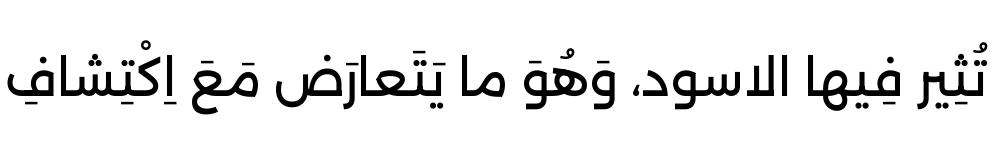

In [13]:
image = dataset[2]['image']
image

In [14]:
qwen_extract_ocr(text_prompt,image=dataset[2]['image'])


['فيها الأسود، وهو ما يتعارض مع اكتشاف تثير']

In [15]:

for i, sample in enumerate(results):
    torch.cuda.empty_cache()
    image = sample['image']
    text_result = " ".join(qwen_extract_ocr(text_prompt,image=image)).replace("The Arabic text in the image is:\n\n","")
    print(text_result)
    print("*****"*40)
    results[i]['qari'] = text_result

وَإِذَا مَا سَأَلْتُنِي عَن مَّعْنَى لَفْظُهُ "عَرَب" عِندَ
********************************************************************************************************************************************************************************************************
أَما فُهم النُّصوص واسْتِنباط معانيها يُوجَه صحيحٌ دقيق،
********************************************************************************************************************************************************************************************************
فيها الأسود، وهو ما يتعارض مع اكتشاف تثير
********************************************************************************************************************************************************************************************************


الجماعي، وكانت تصل إلى المرحلة الاشتراكية لسنطرة أكبر.
********************************************************************************************************************************************************************************************************
مَعَهُ مَنْدِيلاً فِيهِ جُردَ قَتَانَ وَقَطَعَ لَحْمَ سَكْبَاجٍ مُبَرَّد
********************************************************************************************************************************************************************************************************
إلى المدارس العامه، ولم يكن في كثير من
********************************************************************************************************************************************************************************************************
The plain text representation of the document is:

مُسبب لظاهره الاحتباس الحراري وله القدرة على إمتصاص
*******************************************************************************************************************************

In [19]:
import re

def remove_diacritics(text):
    diacritics = [
        '\u0617', '\u0618', '\u0619', '\u061A',  # Small high signs
        '\u064B', '\u064C', '\u064D', '\u064E', '\u064F', '\u0650',  # Tanween and basic diacritics
        '\u0651', '\u0652', '\u0653', '\u0654', '\u0655', '\u0656',  # Shadda, sukun, etc.
        '\u0657', '\u0658', '\u0659', '\u065A', '\u065B', '\u065C', 
        '\u065D', '\u065E', '\u065F', '\u0670'   # Additional Arabic diacritics
    ]
    pattern = '[' + ''.join(diacritics) + ']'
    return re.sub(pattern, '', text)
def remove_english_letters(text):
    # Regex pattern to match English letters (a-z and A-Z)
    pattern = r'[a-zA-Z]'
    # Replace English letters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [20]:
def clean_text(text):
    # Replace all tabs and multiple newlines with a single space
    cleaned = re.sub(r'[\n\t]+', ' ', text)
    # Replace multiple spaces with a single space
    cleaned = re.sub(r'\s+', ' ', cleaned)
    # Strip leading/trailing whitespace
    cleaned = cleaned.strip()
    return cleaned

In [21]:
df = pd.DataFrame(results)
df.head()

image  \
0   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=639x114 at 0x7575C8753910>   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1182x147 at 0x7575C87DA110>   
2   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=994x163 at 0x7575C87DA4D0>   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1315x224 at 0x7575C87DAA50>   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1224x129 at 0x7575C87DAFD0>   

                                                                       ground_truth  \
0                           وَإِذا ما سَأَلَتْنِي عَن مَعْنَى لَفَظَهُ "عرب" عِنْدَ   
1              أَمّا فَهُم النُصُوصِ وَاِسْتِنْباط مَعانِيها بِوَجْهٍ صَحِيحٌ دقيق،   
2                          تُثِير فِيها الاسود، وَهُوَ ما يَتَعارَض مَعَ اِكْتِشافِ   
3  الجماعي، وَكادَت تَصِل إِلَى المَرْحَلَةِ الاِشْتِراكِيَّة لِسَيْطَرَةِ أَكْبَرَ   
4                    مَعَهُ مَنْدِيلا فِيهِ جردقتان وَقَطَعَ لَحْم سَكْباج مُبَرَّد   

                                                                       qari  
0               وَإِذَا مَا سَأَلْتُنِي عَن مَّعْنَى لَفْظُهُ "عَرَب" عِندَ  
1                  أَما فُهم النُّصوص واسْتِنباط معانيها يُوجَه صحيحٌ دقيق،  
2                                 فيها الأسود، وهو ما يتعارض مع اكتشاف تثير  
3                    الجماعي، وكانت تصل إلى المرحلة الاشتراكية لسنطرة أكبر.  
4  مَعَهُ مَنْدِيلاً فِيهِ جُردَ قَتَانَ وَقَطَعَ لَحْمَ سَكْبَاجٍ مُبَرَّد

In [23]:
df['ground_truth'] = df['ground_truth'].apply(remove_english_letters).apply(clean_text)
df['qari'] = df['qari'].apply(remove_english_letters).apply(clean_text)

In [24]:

df['ground_truth_t'] = df["ground_truth"].apply(remove_diacritics)
df['qari_t'] = df["qari"].apply(remove_diacritics)


In [25]:
df.head()

image  \
0   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=639x114 at 0x7575C8753910>   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1182x147 at 0x7575C87DA110>   
2   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=994x163 at 0x7575C87DA4D0>   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1315x224 at 0x7575C87DAA50>   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1224x129 at 0x7575C87DAFD0>   

                                                                       ground_truth  \
0                           وَإِذا ما سَأَلَتْنِي عَن مَعْنَى لَفَظَهُ "عرب" عِنْدَ   
1              أَمّا فَهُم النُصُوصِ وَاِسْتِنْباط مَعانِيها بِوَجْهٍ صَحِيحٌ دقيق،   
2                          تُثِير فِيها الاسود، وَهُوَ ما يَتَعارَض مَعَ اِكْتِشافِ   
3  الجماعي، وَكادَت تَصِل إِلَى المَرْحَلَةِ الاِشْتِراكِيَّة لِسَيْطَرَةِ أَكْبَرَ   
4                    مَعَهُ مَنْدِيلا فِيهِ جردقتان وَقَطَعَ لَحْم سَكْباج مُبَرَّد   

                                                                       qari  \
0               وَإِذَا مَا سَأَلْتُنِي عَن مَّعْنَى لَفْظُهُ "عَرَب" عِندَ   
1                  أَما فُهم النُّصوص واسْتِنباط معانيها يُوجَه صحيحٌ دقيق،   
2                                 فيها الأسود، وهو ما يتعارض مع اكتشاف تثير   
3                    الجماعي، وكانت تصل إلى المرحلة الاشتراكية لسنطرة أكبر.   
4  مَعَهُ مَنْدِيلاً فِيهِ جُردَ قَتَانَ وَقَطَعَ لَحْمَ سَكْبَاجٍ مُبَرَّد   

                                          ground_truth_t  \
0                  وإذا ما سألتني عن معنى لفظه "عرب" عند   
1        أما فهم النصوص واستنباط معانيها بوجه صحيح دقيق،   
2              تثير فيها الاسود، وهو ما يتعارض مع اكتشاف   
3  الجماعي، وكادت تصل إلى المرحلة الاشتراكية لسيطرة أكبر   
4             معه منديلا فيه جردقتان وقطع لحم سكباج مبرد   

                                                   qari_t  
0                   وإذا ما سألتني عن معنى لفظه "عرب" عند  
1         أما فهم النصوص واستنباط معانيها يوجه صحيح دقيق،  
2               فيها الأسود، وهو ما يتعارض مع اكتشاف تثير  
3  الجماعي، وكانت تصل إلى المرحلة الاشتراكية لسنطرة أكبر.  
4             معه منديلا فيه جرد قتان وقطع لحم سكباج مبرد

In [26]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qari"]:
    wer_score = wer(df["ground_truth"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qari - WER: 1.11, CER: 0.51


In [27]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qari_t"]:
    wer_score = wer(df["ground_truth_t"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth_t"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qari_t - WER: 0.61, CER: 0.38


In [28]:
df.to_csv("khattat_dl_synthesizear_namma_result.csv")

: 